# Conversation analysis

- number of prompts/conversation turns
- number of prompts per request type
- inv_inf score

correlate with:
- self reported satisfaction
- self reported complexity

In [2]:
import pandas as pd
import sqlite3

from helpers.statistical_tests import run_t_test_on_gender

conn = sqlite3.connect("../../../data/giicg.db")
users = pd.read_sql("Select p.*, c.satisfaction, c.rated_complexity from categorized_prompts p JOIN conversations c on p.conversation_id == c.conversation_id", conn)
conn.close()

In [3]:
prompts_per_conversation = users.groupby(['conversation_id', 'user_id', 'gender', 'satisfaction']).size().reset_index(name="num_prompts")
prompts_per_conversation


,conversation_id,user_id,gender,satisfaction,num_prompts
0,1,6,Man (cisgender),neutral,1
1,2,8,Man (cisgender),somewhat satisfied,2
2,3,11,Woman (cisgender),very satisfied,1
3,5,15,Man (cisgender),somewhat satisfied,3
4,6,16,Woman (cisgender),very satisfied,18
...,...,...,...,...,...
80,86,60,Woman (cisgender),very satisfied,2
81,87,73,Woman (cisgender),somewhat satisfied,9
82,88,77,Man (cisgender),somewhat satisfied,2
83,89,79,Woman (cisgender),somewhat satisfied,9


## Conversation Length

Spearman correlation: -0.151 (p=0.169)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: satisfaction_code
No. Observations: 85      Method:             REML             
No. Groups:       30      Scale:              0.5719           
Min. group size:  1       Log-Likelihood:     -106.0719        
Max. group size:  5       Converged:          Yes              
Mean group size:  2.8                                          
-----------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     4.057      0.109   37.224   0.000    3.844    4.271
num_prompts   0.007      0.005    1.317   0.188   -0.003    0.017
Group Var     0.073      0.092                                   



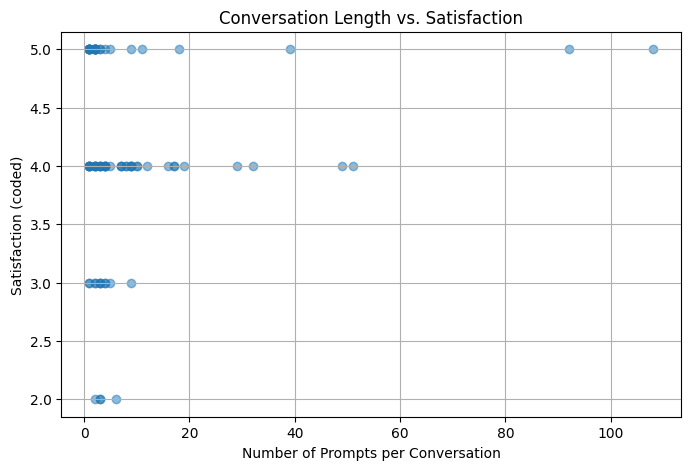

In [4]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Calculate number of prompts per conversation
conversation_lengths = users.groupby(['conversation_id', 'user_id']).size().reset_index(name="num_prompts")
# Get the satisfaction score for each conversation (taking the first for each conversation)
satisfaction_per_conversation = users.groupby('conversation_id').first().reset_index()

# Merge the two to align num_prompts and satisfaction
merged = conversation_lengths.merge(satisfaction_per_conversation[['conversation_id', 'satisfaction']], on='conversation_id')

# If satisfaction is categorical, convert to numerical code
satisfaction_map = {
    'very dissatisfied': 1,
    'mostly dissatisfied': 2,
    'neutral': 3,
    'somewhat satisfied': 4,
    'very satisfied': 5
}
merged['satisfaction_code'] = merged['satisfaction'].map(satisfaction_map)

# Spearman correlation (non-parametric, for ordinal or non-normal data)
spearman_corr, spearman_p = spearmanr(merged['num_prompts'], merged['satisfaction_code'])
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3g})")

import statsmodels.formula.api as smf

# merged: DataFrame with columns 'user_id', 'satisfaction_code', 'num_prompts'
model = smf.mixedlm(
    'satisfaction_code ~ num_prompts',
    merged,
    groups=merged['user_id']
)
result = model.fit()
print(result.summary())




# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(merged['num_prompts'], merged['satisfaction_code'], alpha=0.5)
plt.xlabel('Number of Prompts per Conversation')
plt.ylabel('Satisfaction (coded)')
plt.title('Conversation Length vs. Satisfaction')
plt.grid(True)
plt.show()

## Number of prompts per request type

In [5]:
# Group by conversation_id and user_id, then calculate sum per request_type and normalize

# List of request type columns
request_type_cols = ['can_you_question', 'we_command', 'i_question', 'i_statement', 'unpersonal_command', 'you_command', 'unpersonal_question', 'we_question']

# Sum counts per request_type per conversation
request_type_sum = users.groupby(['conversation_id', 'user_id', 'gender'])[request_type_cols].sum().reset_index()

# Total number of prompts per conversation
prompt_counts = users.groupby(['conversation_id', 'user_id', 'gender']).size().reset_index(name='num_prompts')

# Merge sums and prompt counts
merged = request_type_sum.merge(prompt_counts, on=['conversation_id', 'user_id', 'gender'])

# Normalize each request type by total prompts in that conversation
for col in request_type_cols:
    merged[col + '_norm'] = merged[col] / merged['num_prompts']

# Get satisfaction and complexity for each conversation
meta = users.groupby(['conversation_id']).first().reset_index()
meta_subset = meta[['conversation_id', 'satisfaction', 'rated_complexity']]

# Join meta info back
final = merged.merge(meta_subset, on='conversation_id')

# Keep only relevant columns for final output
final_result = final[['conversation_id', 'user_id', 'gender'] + [col + '_norm' for col in request_type_cols] + ['satisfaction',
                                                                                                      'rated_complexity']]

final_result

,conversation_id,user_id,gender,can_you_question_norm,we_command_norm,i_question_norm,i_statement_norm,unpersonal_command_norm,you_command_norm,unpersonal_question_norm,we_question_norm,satisfaction,rated_complexity
0,1,6,Man (cisgender),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,neutral,neither complex nor simple
1,2,8,Man (cisgender),0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.0,somewhat satisfied,relatively complex
2,3,11,Woman (cisgender),1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,very satisfied,very simple
3,5,15,Man (cisgender),0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.666667,0.0,somewhat satisfied,relatively complex
4,6,16,Woman (cisgender),0.055556,0.000000,0.333333,0.555556,0.222222,0.000000,0.055556,0.0,very satisfied,relatively simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,86,60,Woman (cisgender),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,very satisfied,very simple
81,87,73,Woman (cisgender),0.000000,0.111111,0.000000,0.111111,0.222222,0.555556,0.111111,0.0,somewhat satisfied,neither complex nor simple
82,88,77,Man (cisgender),1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,somewhat satisfied,very simple
83,89,79,Woman (cisgender),0.111111,0.222222,0.111111,0.222222,0.111111,0.111111,0.111111,0.0,somewhat satisfied,relatively complex


In [6]:
satisfaction_map = {
    'very dissatisfied': 1,
    'mostly dissatisfied': 2,
    'neutral': 3,
    'somewhat satisfied': 4,
    'very satisfied': 5
}
final_result['satisfaction_code'] = final_result['satisfaction'].map(satisfaction_map)

# Build the model:
# Random intercept by user_id, fixed effect for can_you_question_norm
model = smf.mixedlm(
    "satisfaction_code ~ can_you_question_norm",
    final_result,
    groups=final_result["user_id"]
)
result = model.fit()

print(result.summary())


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: satisfaction_code
No. Observations: 85      Method:             REML             
No. Groups:       30      Scale:              0.5668           
Min. group size:  1       Log-Likelihood:     -101.8659        
Max. group size:  5       Converged:          Yes              
Mean group size:  2.8                                          
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.043    0.114 35.418 0.000  3.819  4.267
can_you_question_norm 0.460    0.343  1.342 0.180 -0.212  1.131
Group Var             0.079    0.095                           



/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2146/2233274160.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['satisfaction_code'] = final_result['satisfaction'].map(satisfaction_map)


In [7]:
model = smf.mixedlm(
    "satisfaction_code ~ you_command_norm",
    final_result,
    groups=final_result["user_id"]
)
result = model.fit()

print(result.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: satisfaction_code
No. Observations: 85      Method:             REML             
No. Groups:       30      Scale:              0.5681           
Min. group size:  1       Log-Likelihood:     -101.9148        
Max. group size:  5       Converged:          Yes              
Mean group size:  2.8                                          
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.209    0.120 35.203 0.000  3.975  4.443
you_command_norm     -0.435    0.322 -1.351 0.177 -1.067  0.196
Group Var             0.077    0.092                           



In [10]:
corr, p = spearmanr(final_result['you_command_norm'], final_result['satisfaction_code'])
print(f"Spearman correlation: {corr:.3f} (p={p:.3g})")


Spearman correlation: -0.140 (p=0.201)


In [12]:
import statsmodels.formula.api as smf

result = smf.ols('satisfaction_code ~ you_command_norm', data=final_result).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      satisfaction_code   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.453
Date:                Thu, 18 Sep 2025   Prob (F-statistic):              0.232
Time:                        19:48:28   Log-Likelihood:                -101.23
No. Observations:                  85   AIC:                             206.5
Df Residuals:                      83   BIC:                             211.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1962      0.109  

In [14]:
import statsmodels.formula.api as smf

result = smf.ols('satisfaction_code ~ can_you_question_norm', data=final_result).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      satisfaction_code   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.561
Date:                Thu, 18 Sep 2025   Prob (F-statistic):              0.215
Time:                        19:49:21   Log-Likelihood:                -101.18
No. Observations:                  85   AIC:                             206.4
Df Residuals:                      83   BIC:                             211.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.04

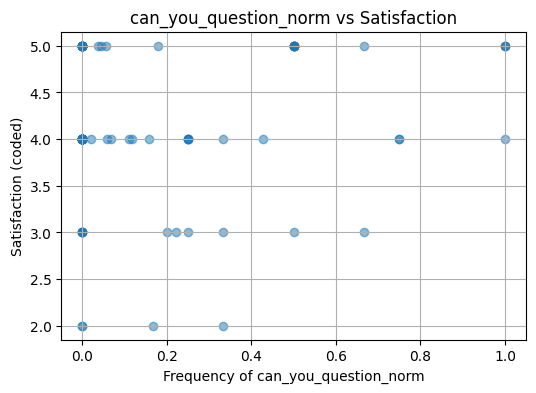

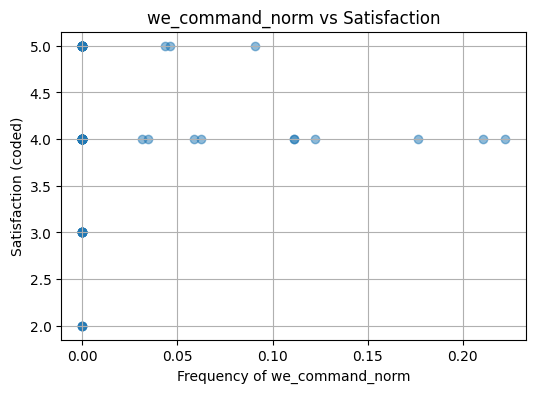

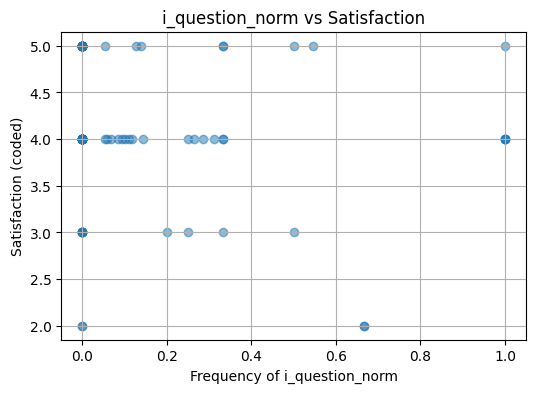

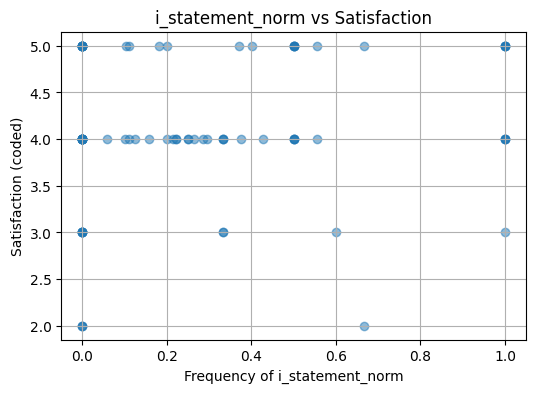

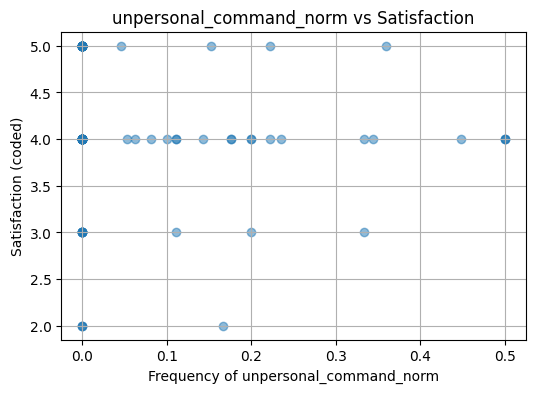

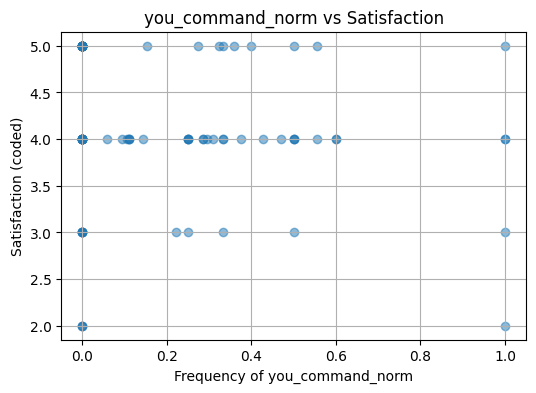

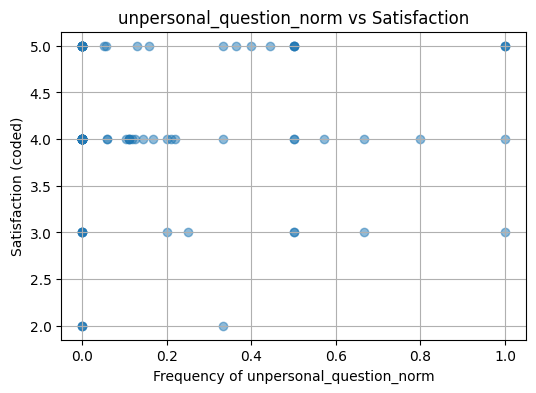

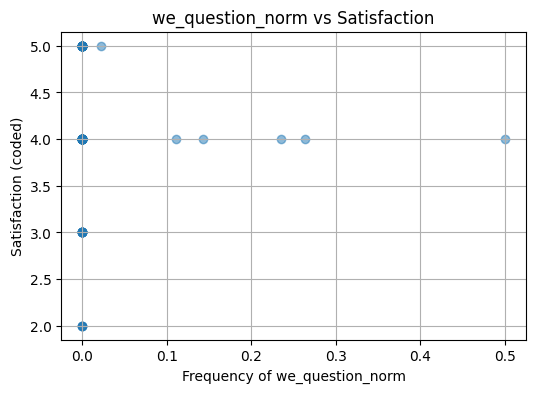

In [15]:

request_types = [
    'can_you_question_norm', 'we_command_norm', 'i_question_norm', 'i_statement_norm',
    'unpersonal_command_norm', 'you_command_norm', 'unpersonal_question_norm', 'we_question_norm'
]

for col in request_types:
    plt.figure(figsize=(6, 4))
    plt.scatter(final_result[col], final_result['satisfaction_code'], alpha=0.5)
    plt.xlabel(f'Frequency of {col}')
    plt.ylabel('Satisfaction (coded)')
    plt.title(f'{col} vs Satisfaction')
    plt.grid(True)
    plt.show()


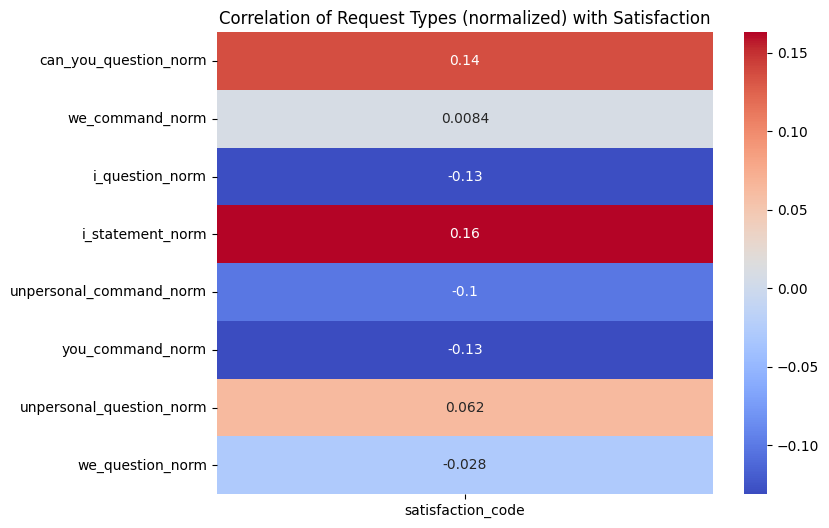

In [17]:
import seaborn as sns

corrs = final_result[[col for col in final_result.columns if col.endswith('_norm')] + ['satisfaction_code']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corrs[['satisfaction_code']].drop('satisfaction_code'), annot=True, cmap='coolwarm')
plt.title('Correlation of Request Types (normalized) with Satisfaction')
plt.show()
